In [1]:
# Data Manipulation and Preprocessing
import numpy as np
import pandas as pd
import json
import labtools

# Data Visualization
import matplotlib.pyplot as plt

import warnings
# Suppress the SettingWithCopyWarning
warnings.filterwarnings('ignore')

# Web Interaction and Display
from IPython.display import Image, display, HTML

# Additional JavaScript for toggling code display in Jupyter Notebooks
HTML(
    """
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
"""
)

In [2]:
final_df = pd.read_csv('final_df.csv')

<div style="background-color:#711012; padding: 10px 0;">
    <center><h2 style="color: white; font-weight:bold">SUPPLEMENTARY NOTEBOOK 
        (1995-2000)</h2></center>
</div>

This notebook contains the implementation of the clustering method applied to the abstracts of research publications released between 1995 and 2000.

---

<div style="background-color:#711012; padding: 10px 0;">
    <center><h2 style="color: white; font-weight:bold">TOKEN VECTORIZATION</h2></center>
</div>

This is a snippet of a list of consolidated abstracts of two publications submitted between 1995 and 2000.

In [3]:
# Get the 1995-2000 data
window = list(range(1995, 2001))
df_1995 = final_df[final_df.year.isin(window)]

# Get the abstract of the 1995 dataset
abs_1995 = df_1995.abstract.to_list()
print(abs_1995[:2])

['  We develop numerical homotopy algorithms for solving systems of polynomial\nequations arising from the classical Schubert calculus. These homotopies are\noptimal in that generically no paths diverge. For problems defined by\nhypersurface Schubert conditions we give two algorithms based on extrinsic\ndeformations of the Grassmannian: one is derived from a Gr\\"obner basis for the\nPl\\"ucker ideal of the Grassmannian and the other from a SAGBI basis for its\nprojective coordinate ring. The more general case of special Schubert\nconditions is solved by delicate intrinsic deformations, called Pieri\nhomotopies, which first arose in the study of enumerative geometry over the\nreal numbers. Computational results are presented and applications to control\ntheory are discussed.\n', '  The knowledge discovery potential of the new large astronomical databases is\nvast. When these are used in conjunction with the rich legacy data archives,\nthe opportunities for scientific discovery multiply

We next create a matrix representing certain words on this list as a column and their corresponding frequencies within each abstract as values in the matrix. This matrix allows for quantitative analysis of the abstracts based on the occurrence of specific keywords or terms. 

To determine the optimal values for `min_df` and `max_df`, we created a heatmap that shows the sparsity of the TF-IDF matrix for different combinations of `min_df` and `max_df` values. The sparsity is calculated as the ratio of zero elements in the matrix to the total number of elements.

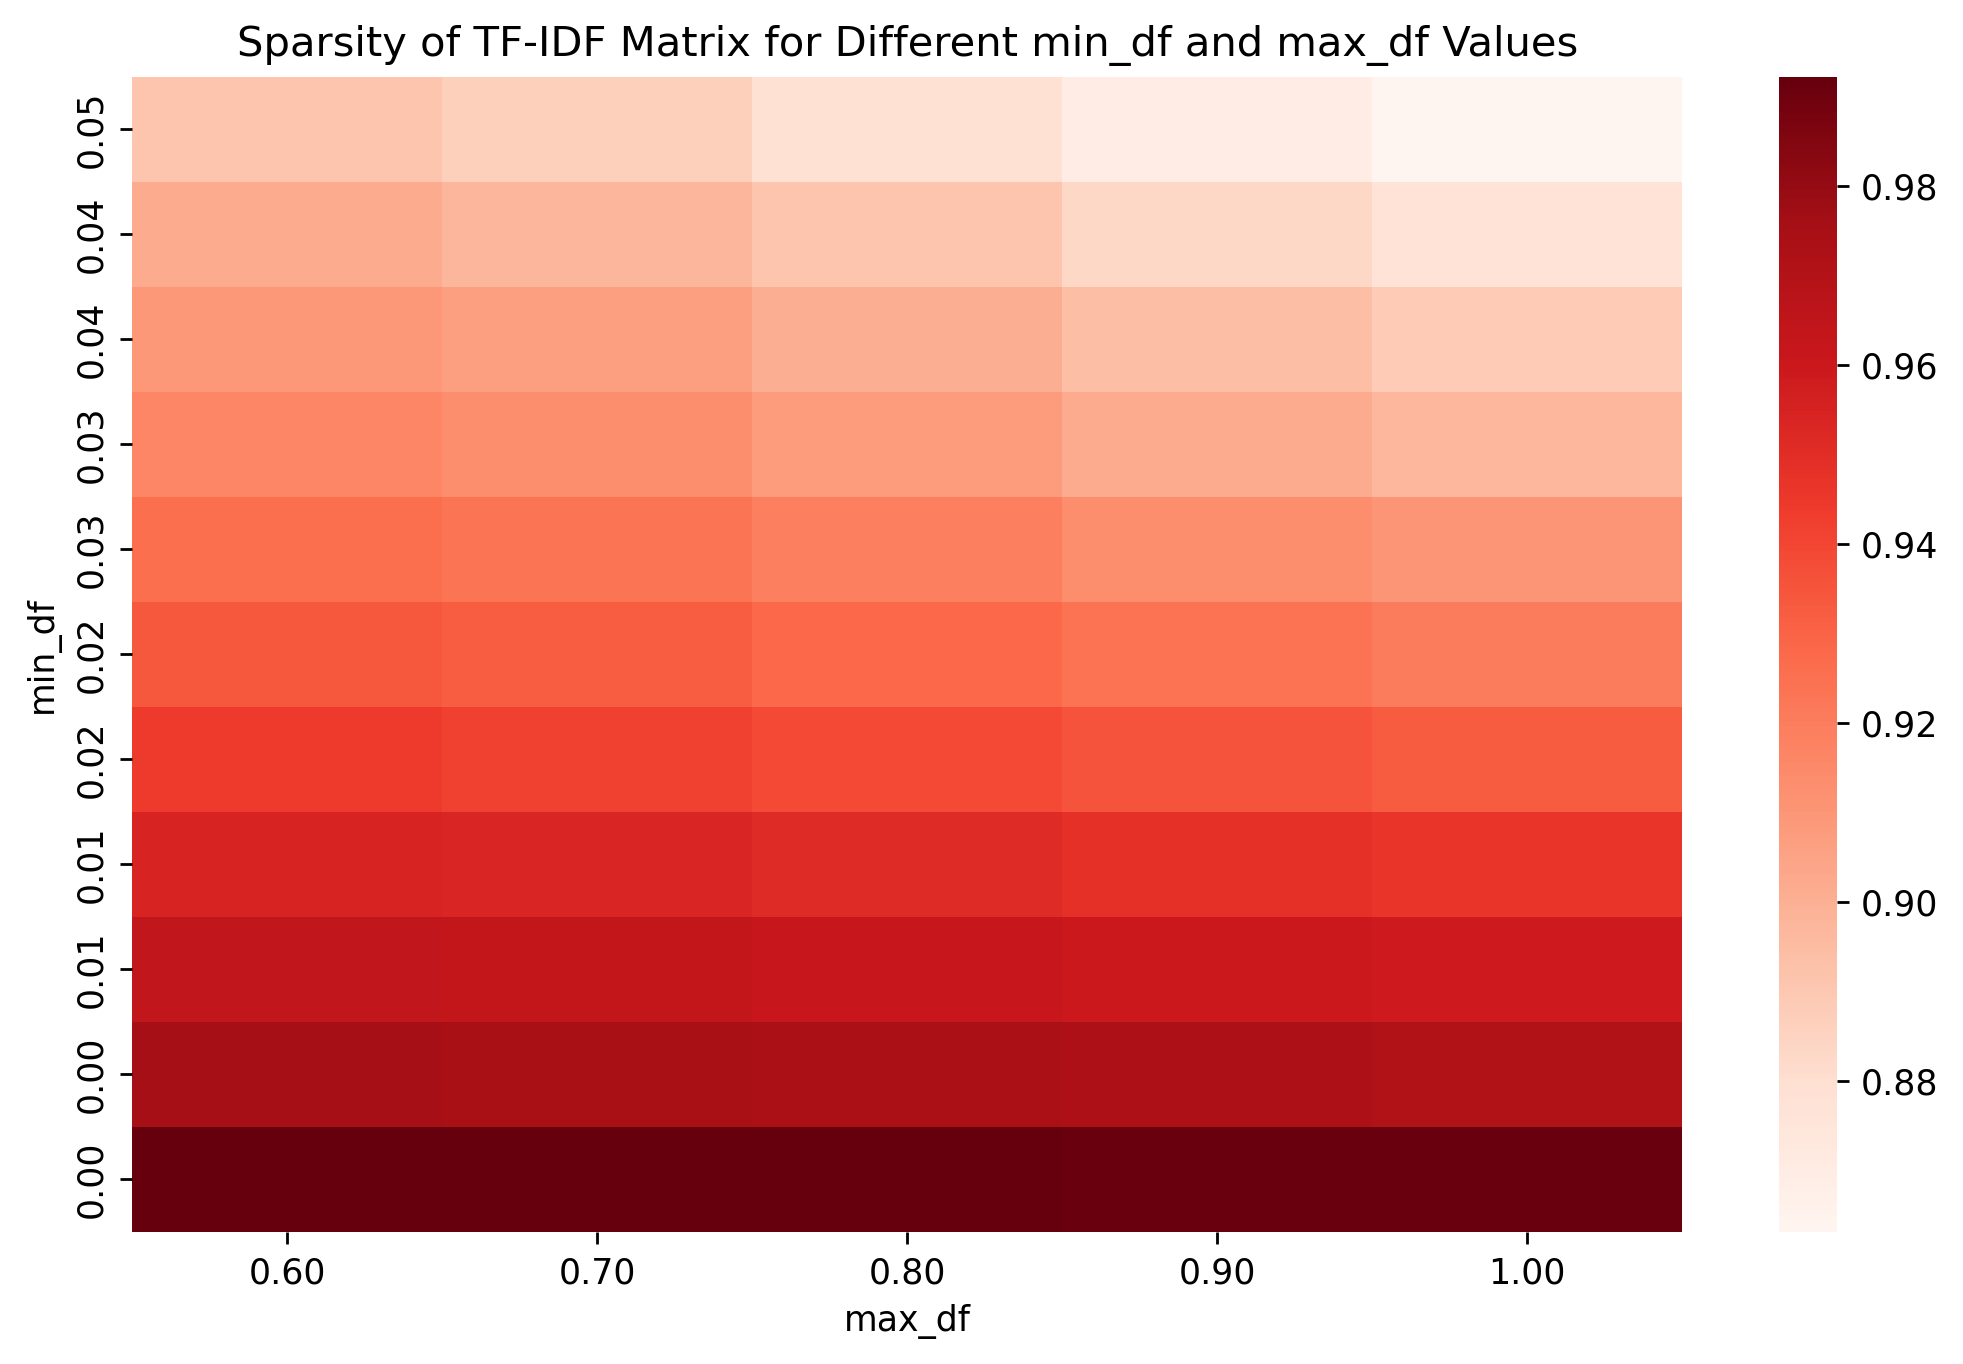

In [4]:
labtools.visualize_sparsity(abs_1995)

<center>
    <h6>
        <b>Figure 1. 
        </b> Sparsity of TF-IDF Matrix for Different <code>min_df</code> and<code>max_df</code> values
    </h6>
</center>

- **Lower right corner (high `min_df`, low `max_df`)**: This region has the lowest sparsity, indicating that most terms are included in the vocabulary due to the lenient filtering.
- **Upper left corner (low `min_df`, high `max_df`)**: This region has the highest sparsity, indicating that many terms have been excluded from the vocabulary due to the aggressive filtering of rare and common terms.
- **Diagonal trend**: As you move from the upper left corner to the lower right corner, the sparsity generally increases. This is because increasing `min_df` and decreasing `max_df` results in more aggressive filtering of the vocabulary.

The heatmap highlights the trade-off between sparsity and vocabulary size. A sparser matrix (higher sparsity) may be more computationally efficient, but it may also exclude important terms. A denser matrix (lower sparsity) includes more terms but may also include noise.

We chose the middle of the heatmap as the optimal region for the values of `min_df` and `max_df`, indicating a balance between including informative terms and excluding noise.

Let's also remove English and context-specific stopwords. Our resulting matrix looks like this:

In [5]:
df_tfidf_95 = labtools.vectorize_abstract(abs_1995, min_df=0.03, max_df=0.8)
df_tfidf_95.head(3)

algorithms  approximate  approximation  asymptotic  basic     basis  \
0    0.317178          0.0            0.0         0.0    0.0  0.386689   
1    0.000000          0.0            0.0         0.0    0.0  0.000000   
2    0.000000          0.0            0.0         0.0    0.0  0.000000   

   behavior  bound  boundary  bounded  ...  studied  sufficient  symmetric  \
0       0.0    0.0       0.0      0.0  ...      0.0         0.0        0.0   
1       0.0    0.0       0.0      0.0  ...      0.0         0.0        0.0   
2       0.0    0.0       0.0      0.0  ...      0.0         0.0        0.0   

   techniques  theoretical  times  transition  unique  values  walk  
0         0.0          0.0    0.0         0.0     0.0     0.0   0.0  
1         0.0          0.0    0.0         0.0     0.0     0.0   0.0  
2         0.0          0.0    0.0         0.0     0.0     0.0   0.0  

[3 rows x 184 columns]

<center>
    <h6>
        <b>Table 1. 
        </b>TF-IDF Matrix
    </h6>
</center>

<div style="background-color:#711012; padding: 10px 0;">
    <center><h2 style="color: white; font-weight:bold">DIMENSIONALITY REDUCTION</h2></center>
</div>

Next, we reduce the complexity of the dataset by decreasing the number of its dimensions. We first determine the number of singular vectors that would give us at least 90% of the variance explained using the `TruncatedSVD` method.

Number of components for at least 90% variance explained: 131


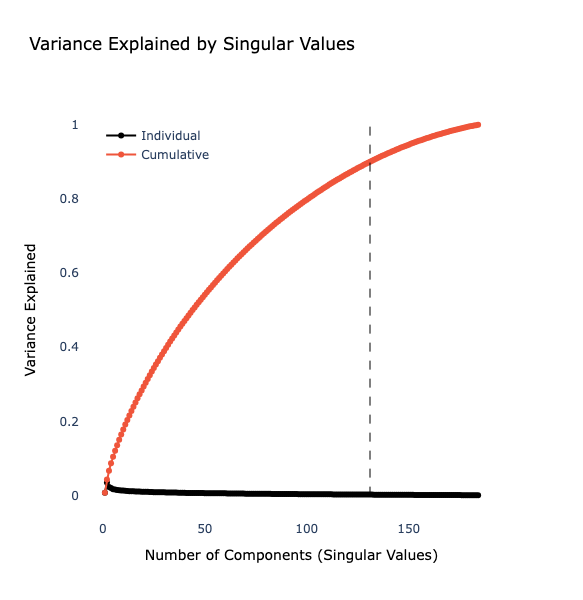

131

In [6]:
labtools.get_n_components(df_tfidf_95, show_viz=True)

<center>
    <h6>
        <b>Figure 2. 
        </b> Individual and Cumulative Variance Explained of the SV Components
    </h6>
</center>


We then proceed to reducing the number of dimensions of our dataset based on the initial check.

In [7]:
reduced_95 = labtools.reduce_dimensions(labtools.get_n_components(df_tfidf_95, 
                                                         show_viz=False),
                                        df_tfidf_95)

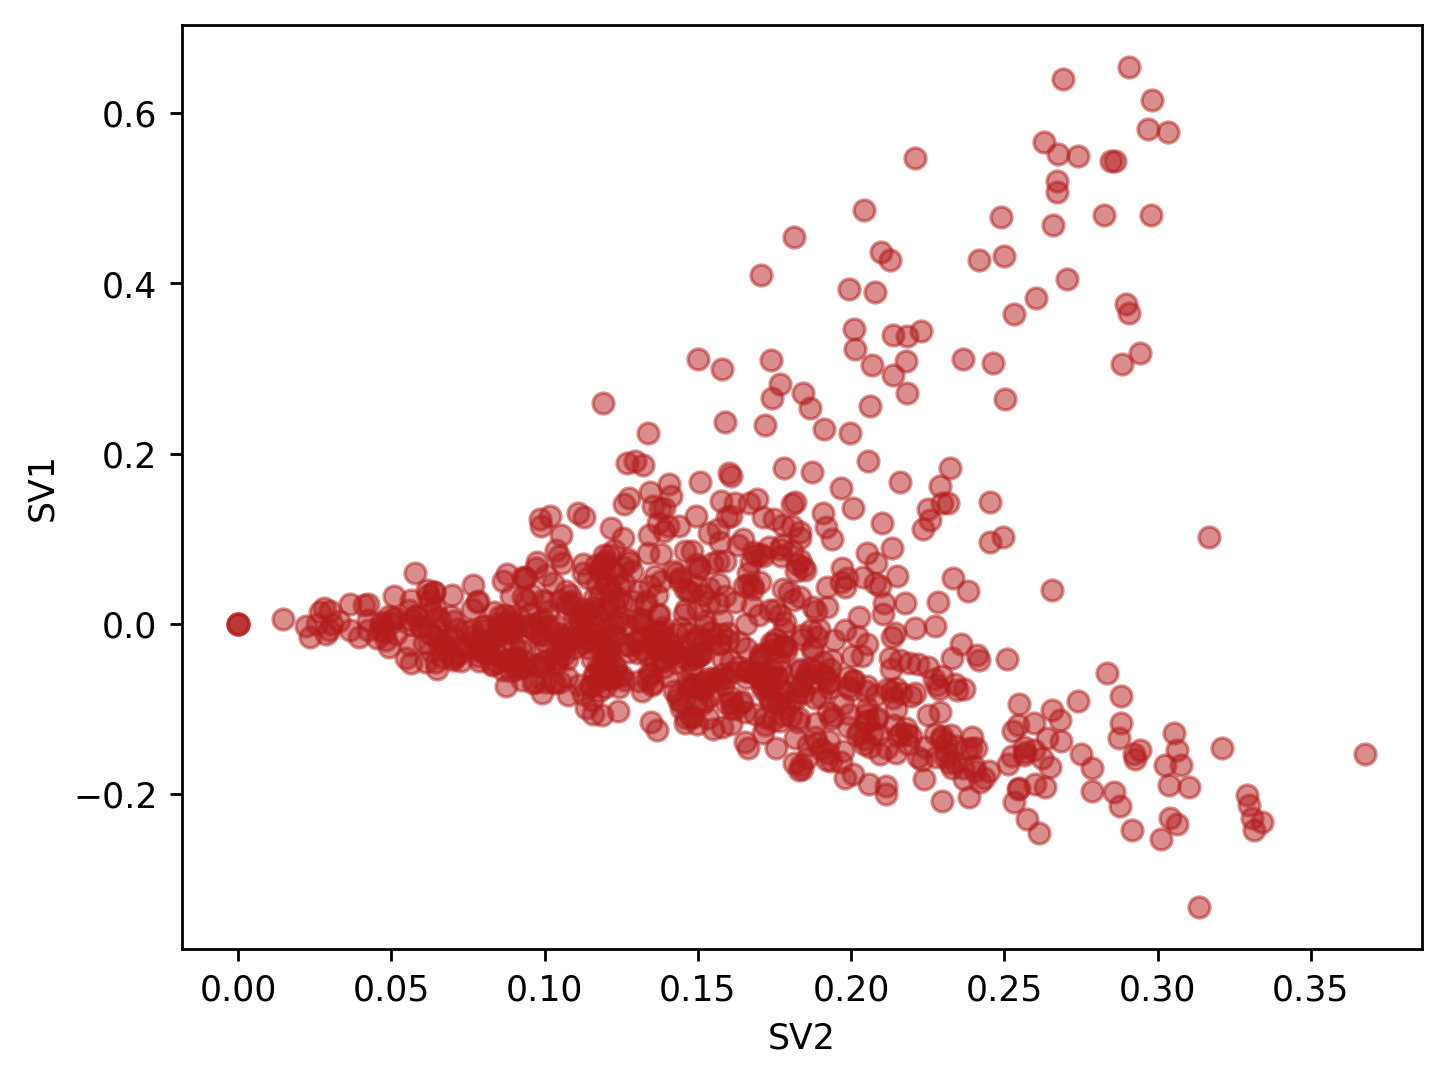

In [8]:
plt.figure(dpi=250)
plt.scatter(reduced_95[:, 0], reduced_95[:, 1], alpha=0.5, color='#b41c1c')
plt.xlabel('SV2')
plt.ylabel('SV1');

<center>
    <h6>
        <b>Figure 3. 
        </b> The TF-IDF as projected to the first two singular vectors
    </h6>
</center>


<div style="background-color:#711012; padding: 10px 0;">
    <center><h2 style="color: white; font-weight:bold">CLUSTERING</h2></center>
</div>

Optimal number of clusters: 2
Threshold distance: 4.194218


4.194217767953611

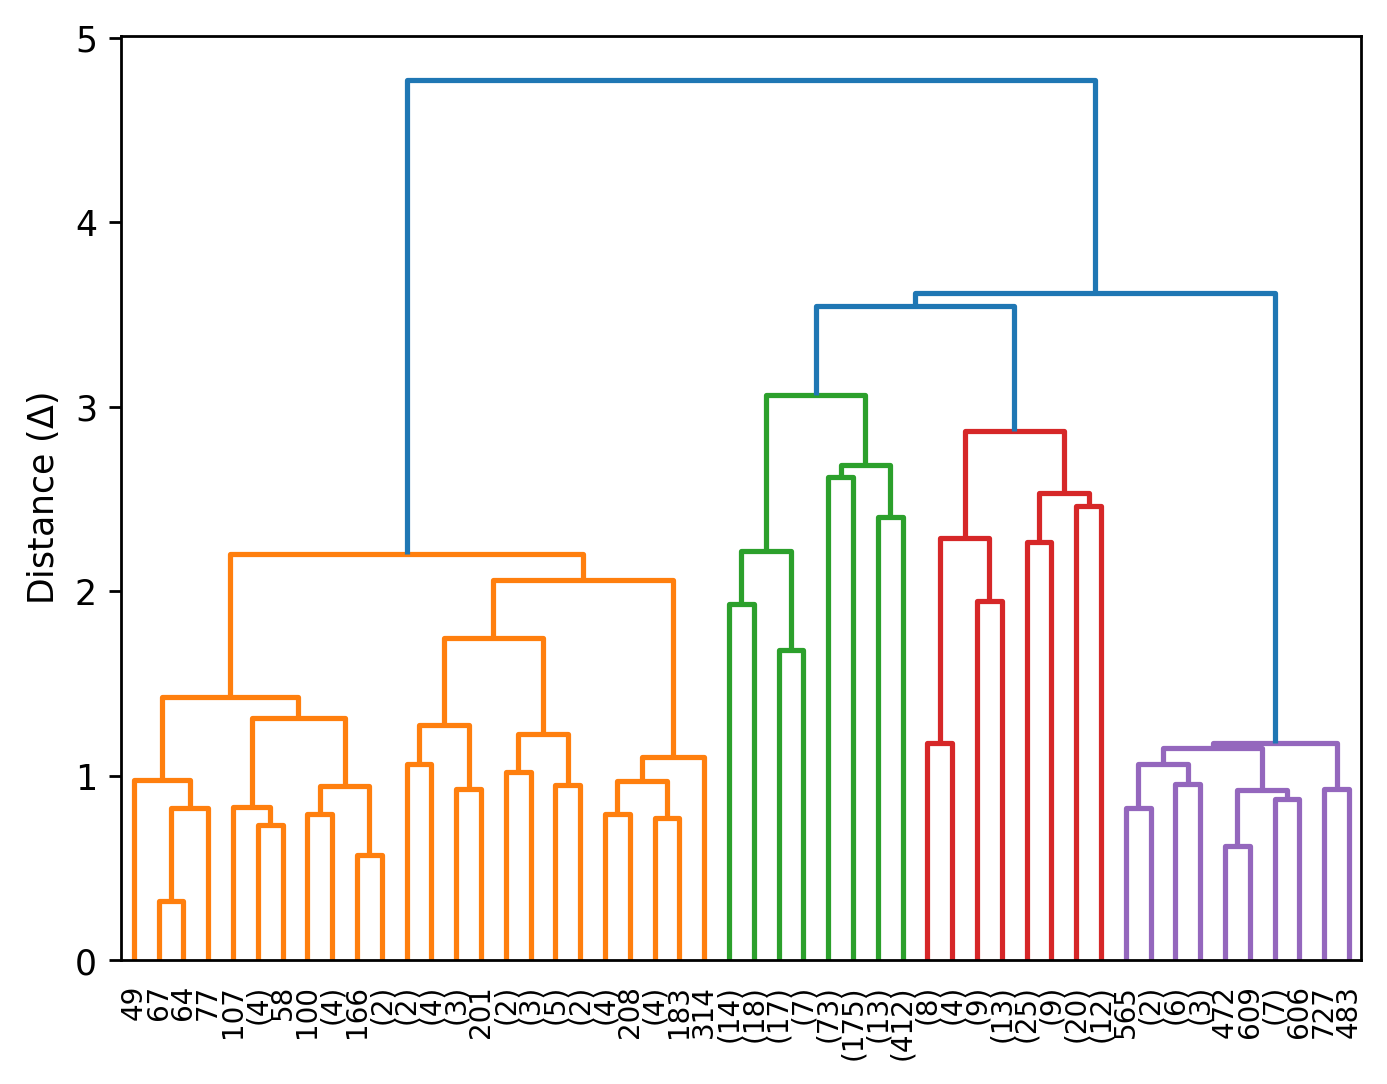

In [9]:
labtools.hierarchical_clustering(reduced_95)

<center>
    <h6>
        <b>Figure 4. 
        </b> Ward's Clustering Dendrogram Results
    </h6>
</center>


From the dendrogram, we see that the optimal number of clusters is two. However, it would be interesting to investigate the sub-clusters that were formed under each main cluster because we can see that one main cluster has more points, so it is possible that we can further find subgroups under it. Let's check these both.

<div style="background-color: #cbc6c6; padding: 10px 0;">
    <center><h4 style="color: #242424;font-weight:bold">EDA on Main Clusters</h4></center>
</div>

Let's first check the two main clusters. This is what it looks when projected on the first two singular vectors:

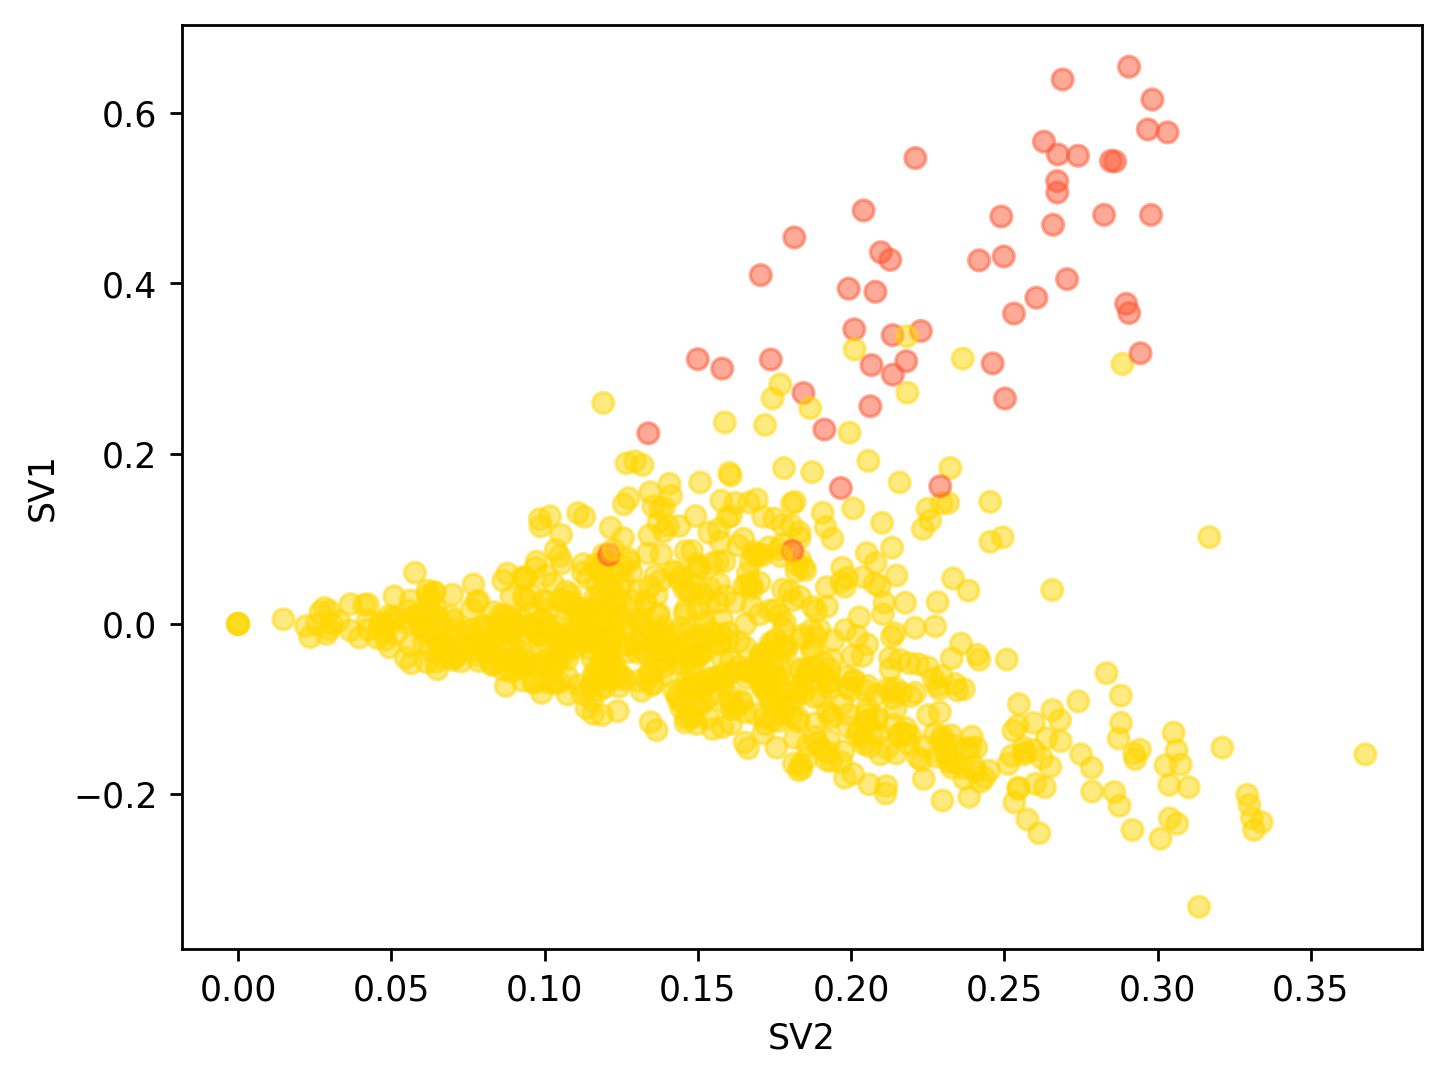

In [10]:
labtools.cluster_predict(reduced_95, df_1995, show_viz=True)

<center>
    <h6>
        <b>Figure 5. 
        </b> Clustering Results as Projected on the First Two Singular Vectors
    </h6>
</center>

Let's visualize the abstracts of the publications belonging to each main cluster using a word cloud to have an idea on what the cluster is all about.

In [11]:
clustered_df = labtools.cluster_predict(reduced_95, df_1995, show_viz=False,
                               get_updated_df=True)

#### **Cluster 1: 1995-2000**

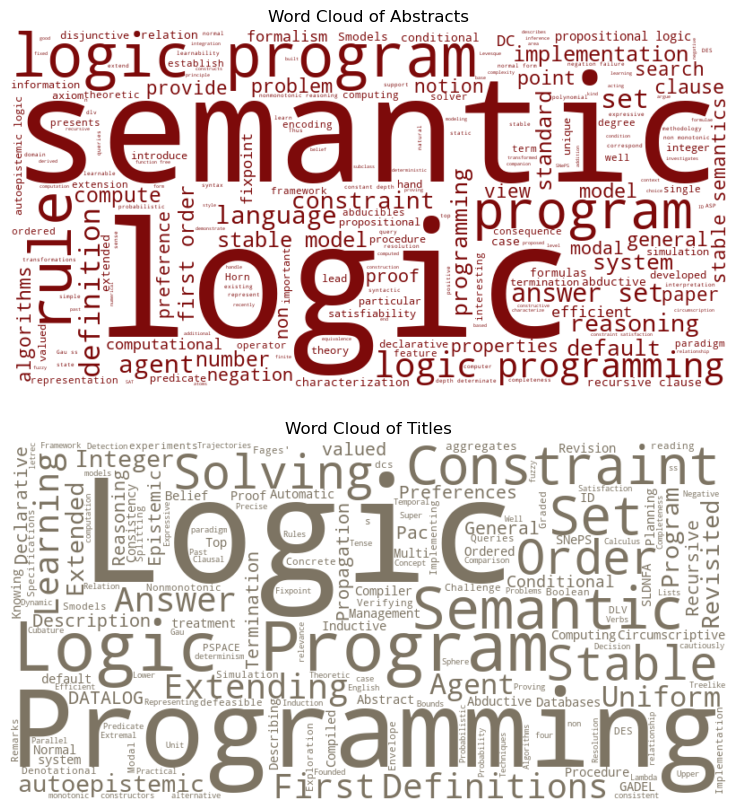

In [12]:
labtools.generate_wordclouds(clustered_df, cluster_number=1)

<center>
    <h6>
        <b>Figure 6. 
        </b> Word Cloud of Initial Cluster 1
    </h6>
</center>

#### **Cluster 2: 1995-2000**

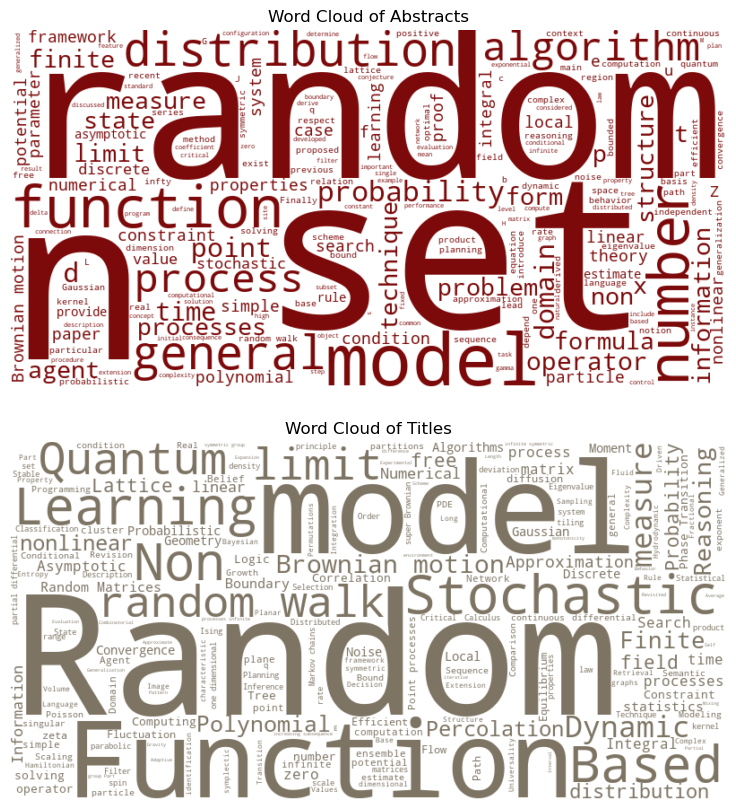

In [13]:
labtools.generate_wordclouds(clustered_df, cluster_number=2)

<center>
    <h6>
        <b>Figure 7. 
        </b> Word Cloud of Initial Cluster 2
    </h6>
</center>

**How imbalanced are our main clusters between 1995 and 2000?**

As we can see, Cluster 2 has significantly more points than Cluster 1. Because of this, it could be worth investigating its sub-clusters. 

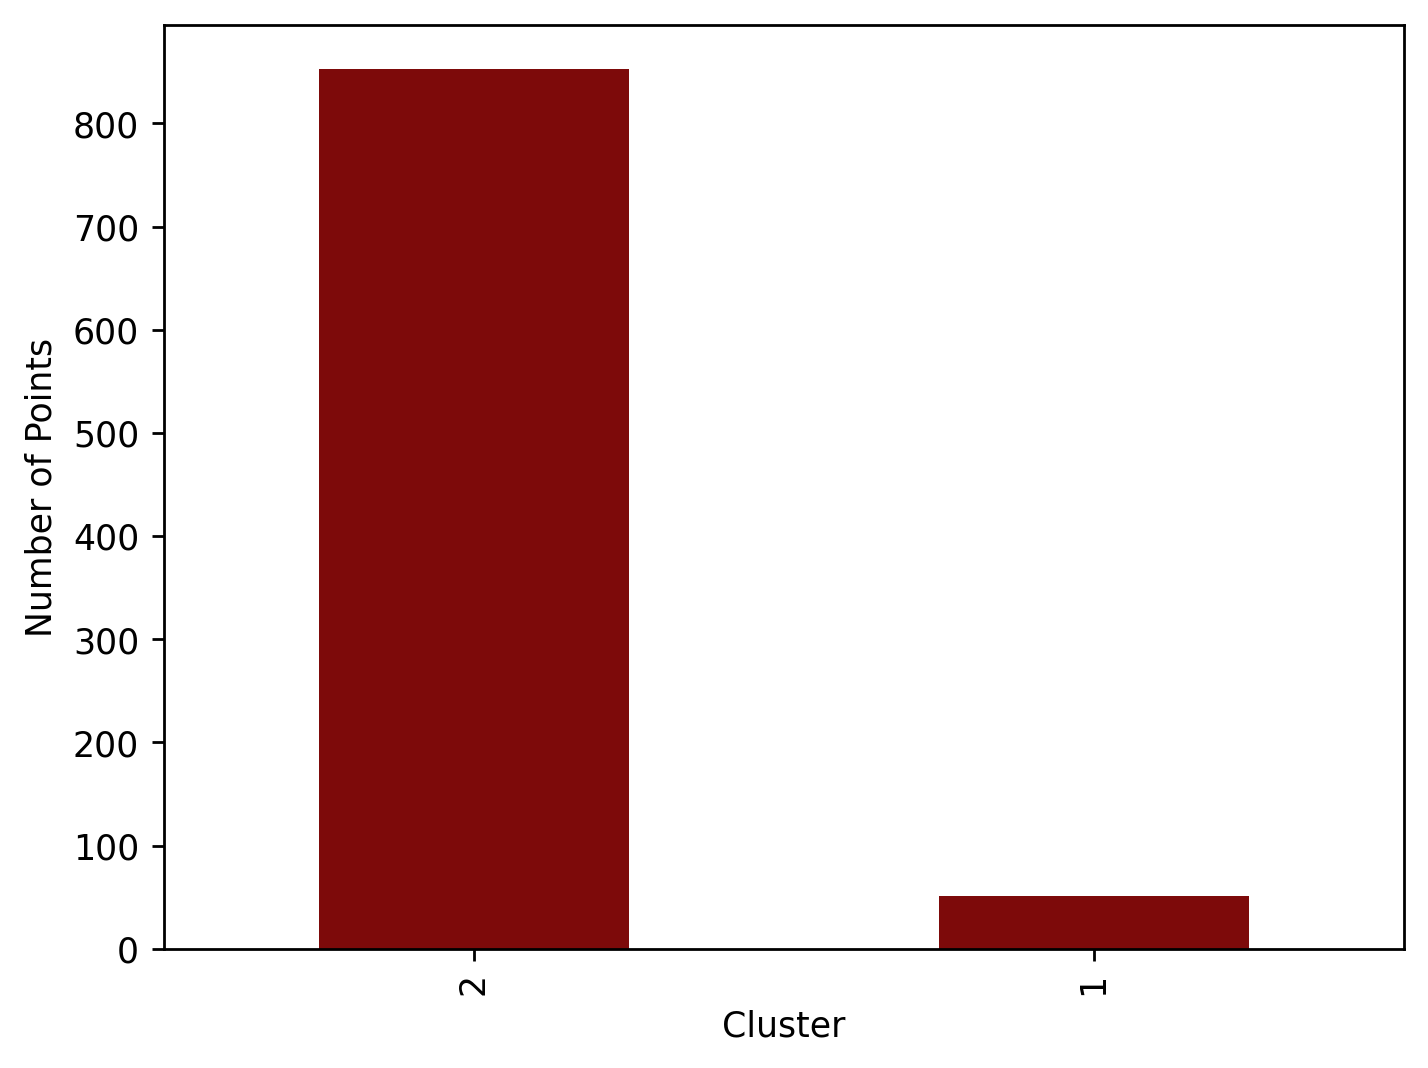

In [14]:
plt.figure(dpi=250)
clustered_df.cluster.value_counts().plot(kind='bar', color='#7d0a0a',
                                         xlabel='Cluster',
                                         ylabel='Number of Points');

<center>
    <h6>
        <b>Figure 8. 
        </b> Visualizing the Distribution of Points to the Initial Clusters
    </h6>
</center>

To do this, we refer back to our dendrogram and change our threshold so that we would capture the subclusters of the large main cluster. Through eyeballing it, a threshold of 3.3 would suffice. The resulting distribution looks like this:

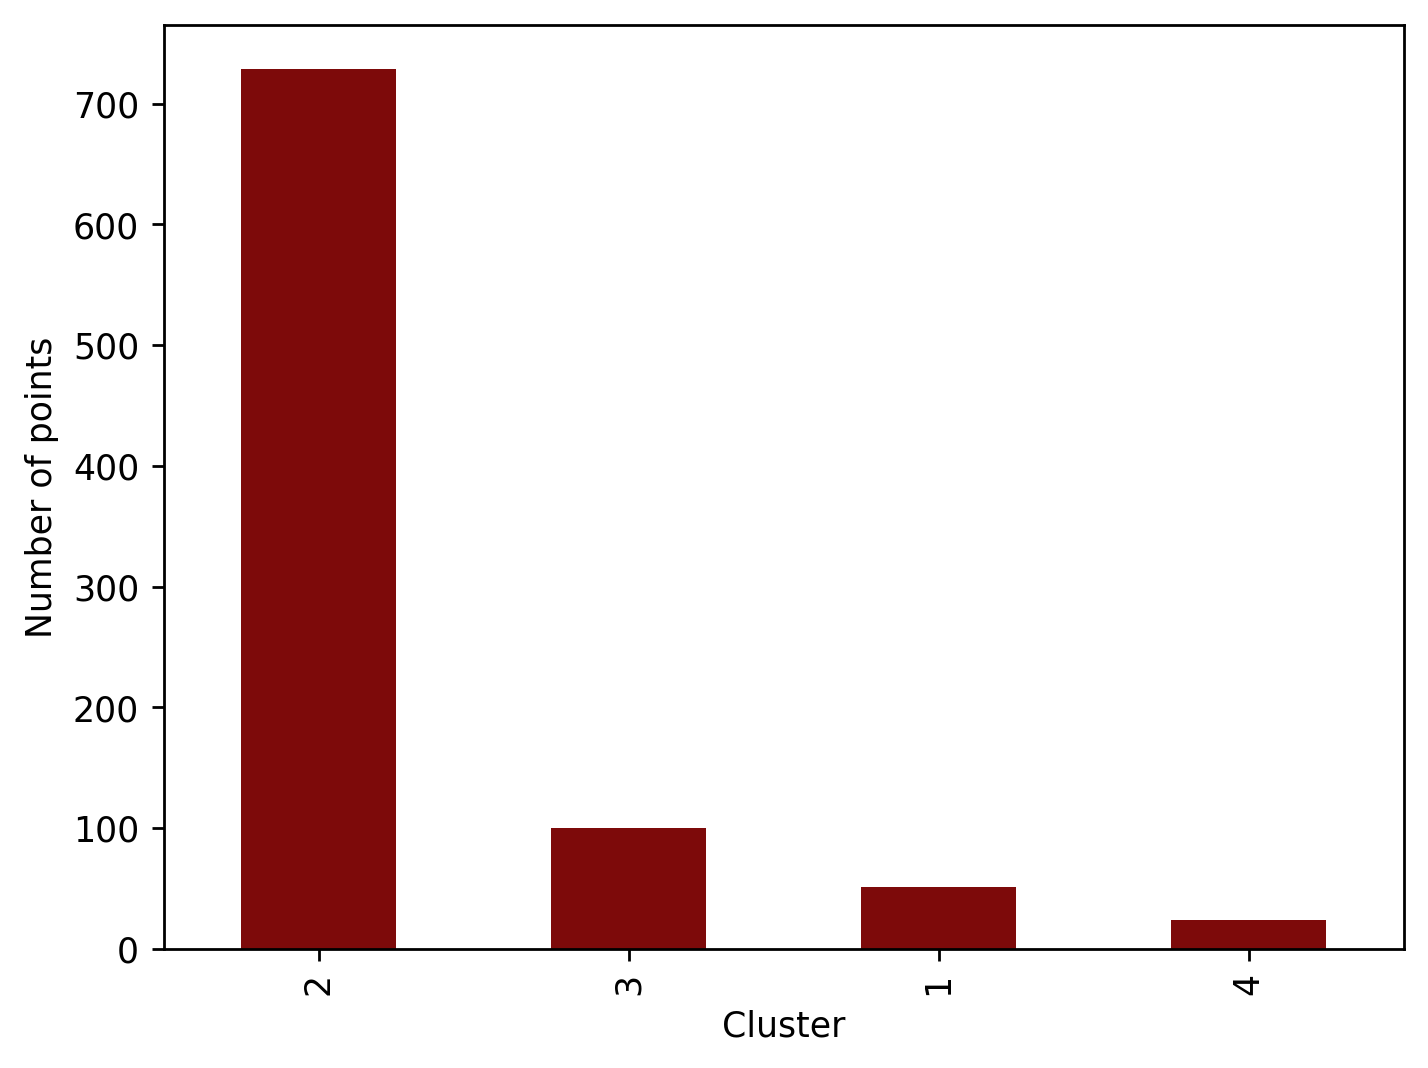

In [15]:
clustered_df = labtools.cluster_predict(reduced_95, df_1995, show_viz=False, 
                               get_updated_df=True, thres=3.3)

plt.figure(dpi=250)
clustered_df.cluster.value_counts().plot(kind='bar', color='#7d0a0a', 
                                         xlabel='Cluster',
                                         ylabel='Number of points');

<center>
    <h6>
        <b>Figure 9. 
        </b> Visualizing the Distribution of Points after Re-clustering
    </h6>
</center>

Although one cluster still dominates the others with respect to the number of points, the general distribution of the points improved. Let's see what words compose each of these clusters.

#### **Final Cluster 1 (1995-2000)**

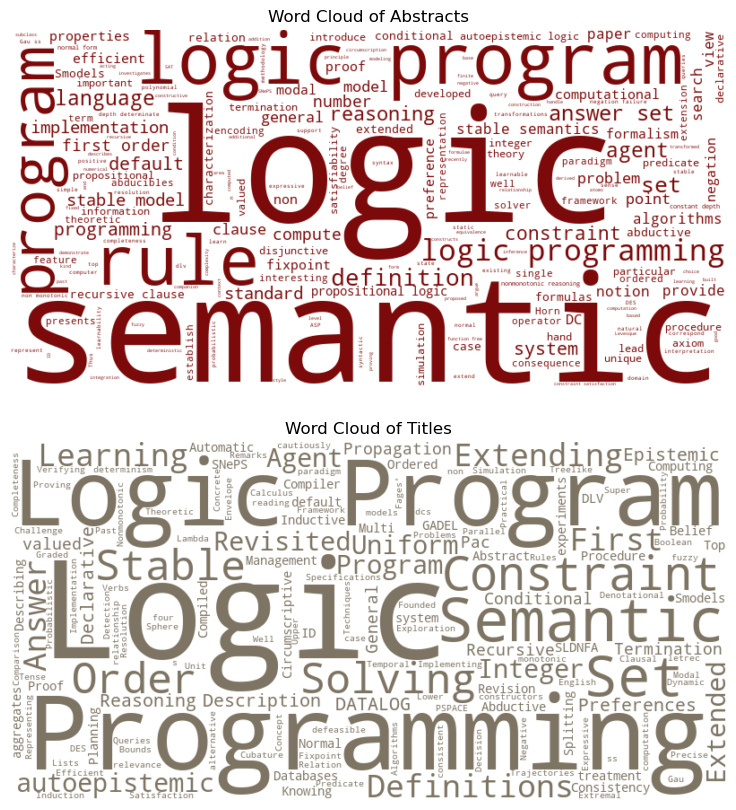

In [16]:
# Cluster 1: 1995-2000
labtools.generate_wordclouds(clustered_df, cluster_number=1)

<center>
    <h6>
        <b>Figure 10. 
        </b> Word Cloud of Final Cluster 1 (1995-2000)
    </h6>
</center>

#### **Final Cluster 2 (1995-2000)**

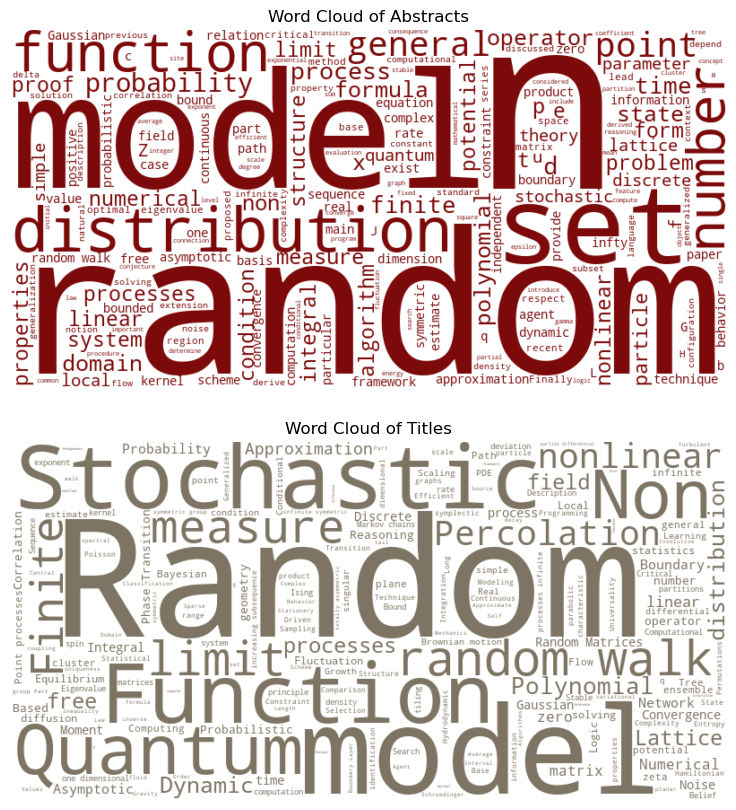

In [17]:
# Cluster 2: 1995-2000
labtools.generate_wordclouds(clustered_df, cluster_number=2)

<center>
    <h6>
        <b>Figure 11. 
        </b> Word Cloud of Final Cluster 2 (1995-2000)
    </h6>
</center>

#### **Final Cluster 3 (1995-2000)**

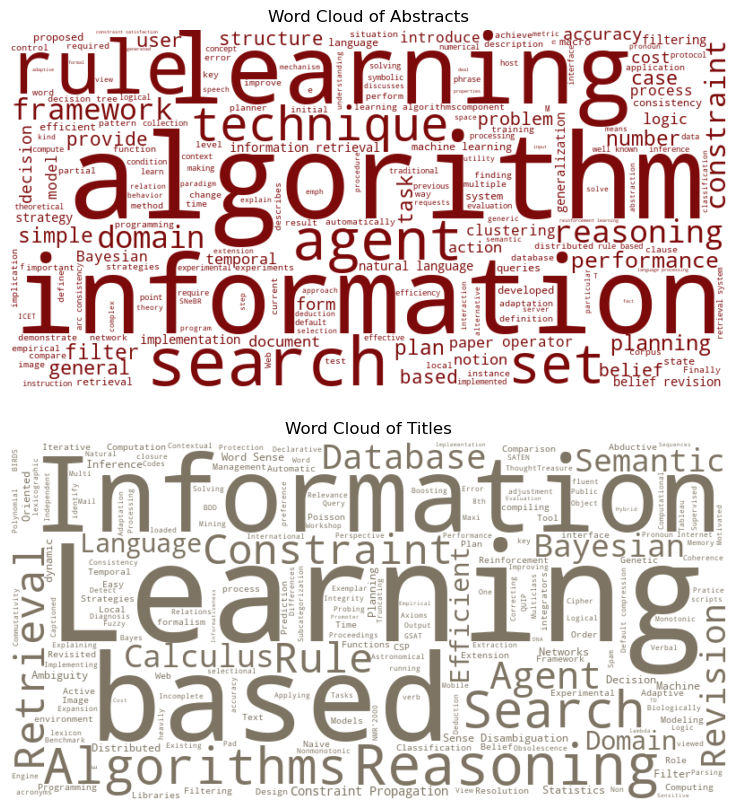

In [18]:
# Cluster 3: 1995-2000
labtools.generate_wordclouds(clustered_df, cluster_number=3)

<center>
    <h6>
        <b>Figure 12. 
        </b> Word Cloud of Final Cluster 3 (1995-2000)
    </h6>
</center>

#### **Final Cluster 4 (1995-2000)**

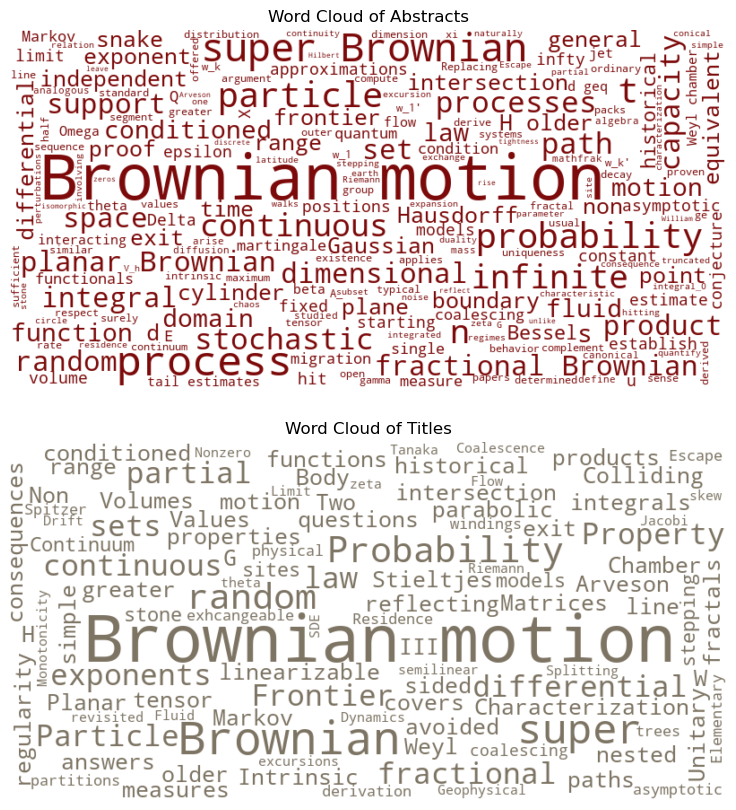

In [19]:
# Cluster 4: 1995-2000
labtools.generate_wordclouds(clustered_df, cluster_number=4)

<center>
    <h6>
        <b>Figure 13. 
        </b> Word Cloud of Final Cluster 4 (1995-2000)
    </h6>
</center>

<div style="background-color:#711012; padding: 10px 0;">
    <center><h2 style="color: white; font-weight:bold">CLUSTER INTERPRETATION</h2></center>
</div>

Based on the corresponding word cloud of each final cluster, the labels are as follows:

#### **Cluster 1: Semantic Logic Programming**
- **Abstract Keywords**: logic, semantic, program, rule
- **Title Keywords**: logic, programming, semantic, constraint

#### **Cluster 2: Stochastic Processes and Random Distributions**
- **Abstract Keywords**: random, set, distribution
- **Title Keywords**: stochastic, random, walk, quantum, percolation, limit, nonlinear, function

#### **Cluster 3: Information Retrieval**
- **Abstract Keywords**: learning, algorithm, information, agent, search, rule, technique
- **Title Keywords**: information, learning, based, search, reasoning, database, Bayesian, retrieval, constraint

#### **Cluster 4: Fractal Properties of Random Processes and Fields**
- **Abstract Keywords**: Brownian motion, probability, stochastic, Hausdorff, particle, processes
- **Title Keywords**: Brownian motion, probability